Adding "Context" to the Network
===============================

The base question here is this: How do we get the network to 'know' that there is a just a phase shift of a sine wave and it has the correct information to regress the noise? The short answer is that we need to show it 'chunks' of data at a time, rather than individual points. We will also need a network big enough that the weights are able to accurately 'shift' each data point by the correct amount of steps. 

In [21]:
# do imports
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(3301)
import scipy.signal as sig
from keras.models import Sequential
from keras.layers import Dense

In [22]:
# let's define the signals
dur = 512
sample_rate = 128
true_freq = 13.4
noise_freq = 5.8
noise_phase = np.pi/2
noise_amp = 0.25
t = np.linspace(0, dur, dur*sample_rate)
s = np.sin(2*np.pi*true_freq * t)
n = noise_amp * np.sin(2*np.pi*noise_freq*t + noise_phase)
d = s + noise_amp * np.sin(2*np.pi*noise_freq*t)  # phase shifted input

In [23]:
# let us again make the training and testing data, but this time we wil split the data into 1 second chunks
input_data = np.zeros((dur, sample_rate))
target_data = np.zeros((dur, sample_rate))
for ii in range(dur):
    st = ii*sample_rate
    et = (ii+1)*sample_rate
    input_data[ii, :] = n[st:et]
    target_data[ii, :] = d[st:et]

print(input_data.shape, target_data.shape)

((512, 128), (512, 128))


We now have 512 samples, each 1 second long. Like before, we will train on the first 504s and test on the last 8. We can now make the training and testing data

In [24]:
train_dur = 504  # seconds
x_train = input_data[:train_dur, :]
y_train = target_data[:train_dur, :]

x_test = input_data[train_dur:, :]
y_test = target_data[train_dur:, :]

print('x_train, y_train', x_train.shape, y_train.shape)
print('x_test, y_test', x_test.shape, y_test.shape)

('x_train, y_train', (504, 128), (504, 128))
('x_test, y_test', (8, 128), (8, 128))


We can now design our network. Keep in mind, the final output is not a scalar, but rather a vector with dimension equal to the sample rate, i.e, a 1 second prediction. Therefore the final layer of our network must be of this same size.

In [25]:
model = Sequential()  # so far so good
model.add(Dense(2*sample_rate, input_dim=x_train.shape[1], activation='linear'))
model.add(Dense(sample_rate))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=sample_rate//2)
y_hat = model.predict(x_test)

Train on 504 samples, validate on 8 samples
Epoch 1/50
504/504 [==============================] - 6s 11ms/step - loss: 0.5258 - val_loss: 0.5044
Epoch 2/50
504/504 [==============================] - 0s 48us/step - loss: 0.5044 - val_loss: 0.5027
Epoch 3/50
504/504 [==============================] - 0s 43us/step - loss: 0.5036 - val_loss: 0.5010
Epoch 4/50
504/504 [==============================] - 0s 40us/step - loss: 0.5020 - val_loss: 0.5036
Epoch 5/50
504/504 [==============================] - 0s 41us/step - loss: 0.5015 - val_loss: 0.4984
Epoch 6/50
504/504 [==============================] - 0s 42us/step - loss: 0.5015 - val_loss: 0.4979
Epoch 7/50
504/504 [==============================] - 0s 48us/step - loss: 0.5013 - val_loss: 0.5006
Epoch 8/50
504/504 [==============================] - 0s 40us/step - loss: 0.5007 - val_loss: 0.5044
Epoch 9/50
504/504 [==============================] - 0s 41us/step - loss: 0.5008 - val_loss: 0.5029
Epoch 10/50
504/504 [==========================

In [26]:
print(y_hat.shape)

(8, 128)


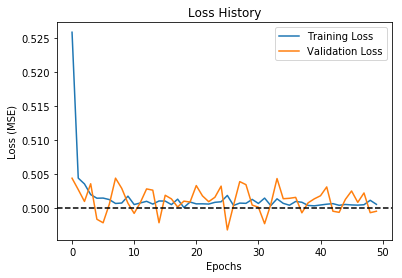

In [27]:
# let's log the loss functions and plot them 
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axhline(0.5, ls='--', color='black')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.show()
plt.close()

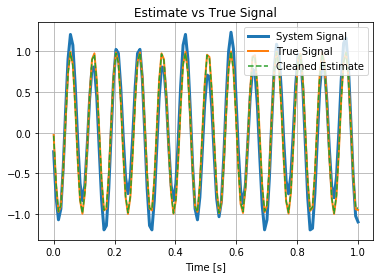

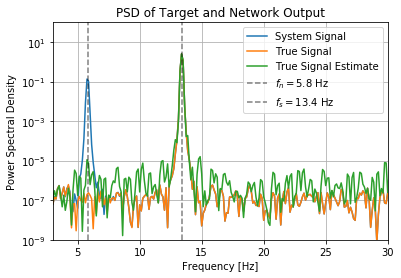

In [28]:
clean = y_test.flatten() - y_hat.flatten()
mse = ((clean - s[-sample_rate*8:])**2).mean()


time = np.linspace(0, 1, sample_rate)
plt.plot(time, y_test.flatten()[-sample_rate:], label='System Signal', lw=3.0)
plt.plot(time, s[-sample_rate:], label='True Signal', lw=2.0)
plt.plot(time, clean[-sample_rate:], label='Cleaned Estimate', ls='--')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('Time [s]')
plt.title('Estimate vs True Signal')
plt.show()
plt.close()


noise_floor = 0.01 * np.random.rand(sample_rate*8)
freq, clean_psd = sig.welch(clean+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, signal_psd = sig.welch(s[-sample_rate*8:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
_, d_psd = sig.welch(d[-sample_rate*8:]+noise_floor, fs=sample_rate, nperseg=sample_rate*8)
plt.semilogy(freq, d_psd, label='System Signal')
plt.semilogy(freq, signal_psd, label='True Signal')
plt.semilogy(freq, clean_psd, label='True Signal Estimate')
plt.axvline(noise_freq, label='$f_n={}$ Hz'.format(noise_freq), ls='--', color='black', alpha=0.5)
plt.axvline(true_freq, label='$f_s={}$ Hz'.format(true_freq), ls='--', color='black', alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.xlim([3,30])
plt.ylim([1e-9, 1e2])
plt.grid(True)
plt.title('PSD of Target and Network Output')
plt.show()
plt.close()

This is certainly looking better. We have removed the noise power from the extra `sin` channel without knowing the phase ahead of time. This isn't perfect, and we could do some tuning if we wanted get a bit more out of this network, but 5 orders of magnitude of supression out of the noise power is good enough for this simple demonstration. 